# PAC sequences 
### import 

In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as scio
import os
import pac
import mne
import pickle
import itertools
from numba import jit, cuda
import functools as ft

In [28]:
list_files_path_name = pd.read_csv('..//task_track_files//task_track_file_pac_sequences_ch.csv',usecols=['local_file_path','preprocessed_one','PAC_sequences_v1'])
num_task_file = list_files_path_name.shape[0]
list_files_path_name

,local_file_path,preprocessed_one,PAC_sequences_v1
0,sub-001\ses-01\eeg\,pre_sub-001_ses-01_task-Rest_eeg.set,PAC_sequences_selected_ch_sub-001_ses-01_task-...
1,sub-001\ses-02\eeg\,pre_sub-001_ses-02_task-Rest_eeg.set,PAC_sequences_selected_ch_sub-001_ses-02_task-...
2,sub-002\ses-01\eeg\,pre_sub-002_ses-01_task-Rest_eeg.set,PAC_sequences_selected_ch_sub-002_ses-01_task-...
3,sub-002\ses-02\eeg\,pre_sub-002_ses-02_task-Rest_eeg.set,PAC_sequences_selected_ch_sub-002_ses-02_task-...
4,sub-003\ses-01\eeg\,pre_sub-003_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-003_ses-01_task-R...
...,...,...,...
70,sub-046\ses-01\eeg\,pre_sub-046_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-046_ses-01_task-R...
71,sub-047\ses-01\eeg\,pre_sub-047_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-047_ses-01_task-R...
72,sub-048\ses-01\eeg\,pre_sub-048_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-048_ses-01_task-R...
73,sub-049\ses-01\eeg\,pre_sub-049_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-049_ses-01_task-R...


## Set parameter

In [33]:
Path = 'D:\Mastersharif\MasterProject\data\parkinsons-oddball'
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
# set timing for s200 and s201 and s202
tmax = 1.450
tmin = 0.250
num_sample_start = int(tmin/0.002)
num_sample_final = int(tmax/0.002)
periods = {'S200':[num_sample_start,num_sample_final],'S201':[num_sample_start,num_sample_final]}
tmin = -0.2
tmax = 1
num_sample_start = int(tmin/0.002)
num_sample_final = int(tmax/0.002)
periods['S202'] = (num_sample_start,num_sample_final)
baseline = {}
tb1 = 0.250
tb2 = 0.450
num_sample_start = tb1/0.002
num_sample_final = tb2/0.002
baseline['S200'] =(num_sample_start,num_sample_final)
baseline['S201'] = (num_sample_start,num_sample_final) 
tb1 = -0.2
tb2 = 0.0
num_sample_start = tb1/0.002
num_sample_final = tb2/0.002
baseline['S202'] = (num_sample_start,num_sample_final)

start_time = -200
end_time = 1000

nobaseline = False

High_fre = 30
Low_fre = 6

start_sample = np.int32((start_time+200)/2)

end_sample = np.int32((end_time+200)/2)

with open('..\data\channels_name.pkl', 'rb') as f:
        channels_name = pickle.load(f)

temp = list(map(lambda x: x in ['AF8','AF7','Fp1','Fp2'],channels_name))

t = np.where(temp)
index_selected_ch = t[0]
h=1


KeyboardInterrupt: 

In [46]:
@jit(parallel=True)
def PAC_sequences_cal():
   for j in np.arange(num_task_file):
      Path_to_load_file = os.path.join(Path,list_files_path_name['local_file_path'][j],list_files_path_name['preprocessed_one'][j])
      Path_to_save_file = os.path.join(Path,list_files_path_name['local_file_path'][j],list_files_path_name['PAC_sequences_v1'][j])
      if not os.path.isfile(Path_to_save_file):
         EEG = mne.io.read_raw_eeglab(Path_to_load_file,eog=(),preload=True)
         eeg_signals = EEG['data'][0]*np.array([1e6],dtype=np.float64)
         events, event_dict = mne.events_from_annotations(EEG, verbose=0)
         events = mne.pick_events(events,include=[event_dict['S200'],event_dict['S201'],event_dict['S202']])
         print(events.shape)
         eeg_trials = np.zeros(shape=(63,events.shape[0],601))
         # calculation of trials with basline correction
         for i,event_detail in enumerate(events):
            if event_detail[2] == event_dict['S200']:
               t = eeg_signals[:,event_detail[0]+periods['S200'][0]:event_detail[0]+periods['S200'][1]+1]
               t = t - np.expand_dims(np.mean(t[:,0:100],axis=1),axis=1) 
               eeg_trials[:,i,0:t.shape[1]] = t
            elif event_detail[2] == event_dict['S201']:
               t = eeg_signals[:,event_detail[0]+periods['S201'][0]:event_detail[0]+periods['S201'][1]+1] 
               t = t - np.expand_dims(np.mean(t[:,0:100],axis=1),axis=1) 
               eeg_trials[:,i,0:t.shape[1]] = t
            elif event_detail[2] == event_dict['S202']:
               t = eeg_signals[:,event_detail[0]+periods['S202'][0]:event_detail[0]+periods['S202'][1]+1] 
               t = t - np.expand_dims(np.mean(t[:,0:100],axis=1),axis=1) 
               eeg_trials[:,i,0:t.shape[1]] =  t  
         
         PAC_sequences = np.zeros(shape=[index_selected_ch.shape[0],eeg_trials.shape[1]])
         for k,ch in enumerate(index_selected_ch):
            for trial in np.arange(eeg_trials.shape[1]):
               PAC_sequences[k,trial] = pac.tfMVL(eeg_trials[ch,trial,start_sample:end_sample+1],high_freq=[High_fre,High_fre],low_freq=[Low_fre,Low_fre],Fs=500)
      
         np.save(Path_to_save_file,PAC_sequences)
      
      # compare the ERP calculation using the above EEG trials with ERP in mne
      # indexes = np.nonzero([events[:,2]==event_dict['S200']])
      # temp = eeg_trials[:,indexes[1],:]
      # ERP1['S200'] = np.mean(temp,axis=1)

      # indexes = np.nonzero([events[:,2]==event_dict['S201']])
      # temp = eeg_trials[:,indexes[1],:]
      # ERP1['S201'] = np.mean(temp,axis=1)

      # indexes = np.nonzero([events[:,2]==event_dict['S202']])
      # temp = eeg_trials[:,indexes[1],:]
      # ERP1['S202'] = np.mean(temp,axis=1)
      # t  = events[events[:,2]==5]
      #     # t1 = mne.pick_events(events,include=[5])
      # t2 = {'S200':5}
      # pochs_1 = mne.Epochs(EEG,events=t,event_id=t2,
      #                 tmin=0.250, tmax=1.450, baseline=(0.250,0.450),preload=True, verbose=0)
      # ERP['S200'] = pochs_1['S200'].average().to_data_frame()
      # del ERP['S200']['time']
      # ERP_array[0,:,:] = np.transpose(ERP['S200'].to_numpy())
      
      # t  = events[events[:,2]==6]
      # t2 = {'S201':6}
      # pochs_1 = mne.Epochs(EEG,events=t,event_id=t2,
      #                 tmin=0.250, tmax=1.450, baseline=(0.250,0.450),preload=True, verbose=0) 
      # ERP['S201'] = pochs_1['S201'].average().to_data_frame() 
      # del ERP['S201']['time']
      # ERP_array[1,:,:] = np.transpose(ERP['S201'].to_numpy())

      # t  = events[events[:,2]==7]
      # t2 = {'S202':7}               
      # pochs_1 = mne.Epochs(EEG,events=t,event_id=t2,
      #                 tmin=-0.2, tmax=1, baseline=(-0.2,0.0),preload=True, verbose=0)  
      # ERP['S202'] = pochs_1['S202'].average().to_data_frame() 
      # del ERP['S202']['time']
      # ERP_array[2,:,:] = np.transpose(ERP['S202'].to_numpy())

if __name__=="__main__":
    PAC_sequences_cal()

    # np.save(f'..\data\PAC_electordes_{start_time}_{end_time}_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}',PAC_on_electrodes)


    
   




                                                 
   

    

C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "PAC_sequences_cal" failed type inference due to: Untyped global name 'list_files_path_name': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "C:\Users\Mohammad\AppData\Local\Temp\ipykernel_9716\2873434368.py", line 4:
<source missing, REPL/exec in use?>

  @jit(parallel=True)
C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "PAC_sequences_cal" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "C:\Users\Mohammad\AppData\Local\Temp\ipykernel_9716\2873434368.py", line 3:
<source missing, REPL/exec in use?>

  @jit(parallel=True)
C:\Users\Mohammad\anaconda3\envs\neuroscience\lib\site-packages\numba\core\object_mode_p

Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-009\ses-01\eeg\pre_sub-009_ses-01_task-Rest_eeg.fdt
Reading 0 ... 238324  =      0.000 ...   476.648 secs...


C:\Users\Mohammad\anaconda3\envs\neuroscience\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "PAC_sequences_cal" was compiled in object mode without forceobj=True.

File "C:\Users\Mohammad\AppData\Local\Temp\ipykernel_9716\2873434368.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\Mohammad\anaconda3\envs\neuroscience\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "C:\Users\Mohammad\AppData\Local\Temp\ipykernel_9716\2873434368.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaDeprecationWarning(msg,
C:\Users\Mohammad\AppData\Local\Temp/ipykernel_97

(63, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-009\ses-02\eeg\pre_sub-009_ses-02_task-Rest_eeg.fdt
Reading 0 ... 290824  =      0.000 ...   581.648 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-010\ses-01\eeg\pre_sub-010_ses-01_task-Rest_eeg.fdt
Reading 0 ... 283649  =      0.000 ...   567.298 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-010\ses-02\eeg\pre_sub-010_ses-02_task-Rest_eeg.fdt
Reading 0 ... 279749  =      0.000 ...   559.498 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-011\ses-01\eeg\pre_sub-011_ses-01_task-Rest_eeg.fdt
Reading 0 ... 292599  =      0.000 ...   585.198 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-011\ses-02\eeg\pre_sub-011_ses-02_task-Rest_eeg.fdt
Reading 0 ... 293499  =      0.000 ...   586.998 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(200, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-012\ses-01\eeg\pre_sub-012_ses-01_task-Rest_eeg.fdt
Reading 0 ... 300674  =      0.000 ...   601.348 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-012\ses-02\eeg\pre_sub-012_ses-02_task-Rest_eeg.fdt
Reading 0 ... 310649  =      0.000 ...   621.298 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-013\ses-01\eeg\pre_sub-013_ses-01_task-Rest_eeg.fdt
Reading 0 ... 293324  =      0.000 ...   586.648 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(200, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-013\ses-02\eeg\pre_sub-013_ses-02_task-Rest_eeg.fdt
Reading 0 ... 276899  =      0.000 ...   553.798 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-014\ses-01\eeg\pre_sub-014_ses-01_task-Rest_eeg.fdt
Reading 0 ... 291049  =      0.000 ...   582.098 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-014\ses-02\eeg\pre_sub-014_ses-02_task-Rest_eeg.fdt
Reading 0 ... 313299  =      0.000 ...   626.598 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(192, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-015\ses-01\eeg\pre_sub-015_ses-01_task-Rest_eeg.fdt
Reading 0 ... 295299  =      0.000 ...   590.598 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(195, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-015\ses-02\eeg\pre_sub-015_ses-02_task-Rest_eeg.fdt
Reading 0 ... 306724  =      0.000 ...   613.448 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-016\ses-01\eeg\pre_sub-016_ses-01_task-Rest_eeg.fdt
Reading 0 ... 310474  =      0.000 ...   620.948 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-016\ses-02\eeg\pre_sub-016_ses-02_task-Rest_eeg.fdt
Reading 0 ... 362599  =      0.000 ...   725.198 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(195, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-017\ses-01\eeg\pre_sub-017_ses-01_task-Rest_eeg.fdt
Reading 0 ... 336299  =      0.000 ...   672.598 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-017\ses-02\eeg\pre_sub-017_ses-02_task-Rest_eeg.fdt
Reading 0 ... 291149  =      0.000 ...   582.298 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-018\ses-01\eeg\pre_sub-018_ses-01_task-Rest_eeg.fdt
Reading 0 ... 293349  =      0.000 ...   586.698 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-018\ses-02\eeg\pre_sub-018_ses-02_task-Rest_eeg.fdt
Reading 0 ... 281749  =      0.000 ...   563.498 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-019\ses-01\eeg\pre_sub-019_ses-01_task-Rest_eeg.fdt
Reading 0 ... 432074  =      0.000 ...   864.148 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-019\ses-02\eeg\pre_sub-019_ses-02_task-Rest_eeg.fdt
Reading 0 ... 288874  =      0.000 ...   577.748 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(200, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-020\ses-01\eeg\pre_sub-020_ses-01_task-Rest_eeg.fdt
Reading 0 ... 304474  =      0.000 ...   608.948 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(199, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-020\ses-02\eeg\pre_sub-020_ses-02_task-Rest_eeg.fdt
Reading 0 ... 285199  =      0.000 ...   570.398 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-021\ses-01\eeg\pre_sub-021_ses-01_task-Rest_eeg.fdt
Reading 0 ... 275724  =      0.000 ...   551.448 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-021\ses-02\eeg\pre_sub-021_ses-02_task-Rest_eeg.fdt
Reading 0 ... 277299  =      0.000 ...   554.598 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-022\ses-01\eeg\pre_sub-022_ses-01_task-Rest_eeg.fdt
Reading 0 ... 330574  =      0.000 ...   661.148 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-022\ses-02\eeg\pre_sub-022_ses-02_task-Rest_eeg.fdt
Reading 0 ... 435049  =      0.000 ...   870.098 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-023\ses-01\eeg\pre_sub-023_ses-01_task-Rest_eeg.fdt
Reading 0 ... 259474  =      0.000 ...   518.948 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-023\ses-02\eeg\pre_sub-023_ses-02_task-Rest_eeg.fdt
Reading 0 ... 253524  =      0.000 ...   507.048 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-024\ses-01\eeg\pre_sub-024_ses-01_task-Rest_eeg.fdt
Reading 0 ... 259099  =      0.000 ...   518.198 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-024\ses-02\eeg\pre_sub-024_ses-02_task-Rest_eeg.fdt
Reading 0 ... 266449  =      0.000 ...   532.898 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(192, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-025\ses-01\eeg\pre_sub-025_ses-01_task-Rest_eeg.fdt
Reading 0 ... 303099  =      0.000 ...   606.198 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(199, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-025\ses-02\eeg\pre_sub-025_ses-02_task-Rest_eeg.fdt
Reading 0 ... 312624  =      0.000 ...   625.248 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(195, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-026\ses-01\eeg\pre_sub-026_ses-01_task-Rest_eeg.fdt
Reading 0 ... 290624  =      0.000 ...   581.248 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-026\ses-02\eeg\pre_sub-026_ses-02_task-Rest_eeg.fdt
Reading 0 ... 333574  =      0.000 ...   667.148 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-027\ses-01\eeg\pre_sub-027_ses-01_task-Rest_eeg.fdt
Reading 0 ... 324199  =      0.000 ...   648.398 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-027\ses-02\eeg\pre_sub-027_ses-02_task-Rest_eeg.fdt
Reading 0 ... 311424  =      0.000 ...   622.848 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-028\ses-01\eeg\pre_sub-028_ses-01_task-Rest_eeg.fdt
Reading 0 ... 278124  =      0.000 ...   556.248 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-029\ses-01\eeg\pre_sub-029_ses-01_task-Rest_eeg.fdt
Reading 0 ... 280274  =      0.000 ...   560.548 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-030\ses-01\eeg\pre_sub-030_ses-01_task-Rest_eeg.fdt
Reading 0 ... 303974  =      0.000 ...   607.948 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(195, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-031\ses-01\eeg\pre_sub-031_ses-01_task-Rest_eeg.fdt
Reading 0 ... 331824  =      0.000 ...   663.648 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-032\ses-01\eeg\pre_sub-032_ses-01_task-Rest_eeg.fdt
Reading 0 ... 328024  =      0.000 ...   656.048 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(200, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-033\ses-01\eeg\pre_sub-033_ses-01_task-Rest_eeg.fdt
Reading 0 ... 464449  =      0.000 ...   928.898 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-034\ses-01\eeg\pre_sub-034_ses-01_task-Rest_eeg.fdt
Reading 0 ... 319374  =      0.000 ...   638.748 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(195, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-035\ses-01\eeg\pre_sub-035_ses-01_task-Rest_eeg.fdt
Reading 0 ... 319499  =      0.000 ...   638.998 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(195, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-036\ses-01\eeg\pre_sub-036_ses-01_task-Rest_eeg.fdt
Reading 0 ... 303124  =      0.000 ...   606.248 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(200, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-037\ses-01\eeg\pre_sub-037_ses-01_task-Rest_eeg.fdt
Reading 0 ... 274949  =      0.000 ...   549.898 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-038\ses-01\eeg\pre_sub-038_ses-01_task-Rest_eeg.fdt
Reading 0 ... 265549  =      0.000 ...   531.098 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-039\ses-01\eeg\pre_sub-039_ses-01_task-Rest_eeg.fdt
Reading 0 ... 346249  =      0.000 ...   692.498 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-040\ses-01\eeg\pre_sub-040_ses-01_task-Rest_eeg.fdt
Reading 0 ... 312249  =      0.000 ...   624.498 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-041\ses-01\eeg\pre_sub-041_ses-01_task-Rest_eeg.fdt
Reading 0 ... 268624  =      0.000 ...   537.248 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(195, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-042\ses-01\eeg\pre_sub-042_ses-01_task-Rest_eeg.fdt
Reading 0 ... 314374  =      0.000 ...   628.748 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-043\ses-01\eeg\pre_sub-043_ses-01_task-Rest_eeg.fdt
Reading 0 ... 285199  =      0.000 ...   570.398 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(195, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-044\ses-01\eeg\pre_sub-044_ses-01_task-Rest_eeg.fdt
Reading 0 ... 278474  =      0.000 ...   556.948 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(197, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-045\ses-01\eeg\pre_sub-045_ses-01_task-Rest_eeg.fdt
Reading 0 ... 273724  =      0.000 ...   547.448 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(193, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-046\ses-01\eeg\pre_sub-046_ses-01_task-Rest_eeg.fdt
Reading 0 ... 284874  =      0.000 ...   569.748 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(196, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-047\ses-01\eeg\pre_sub-047_ses-01_task-Rest_eeg.fdt
Reading 0 ... 257249  =      0.000 ...   514.498 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-048\ses-01\eeg\pre_sub-048_ses-01_task-Rest_eeg.fdt
Reading 0 ... 302399  =      0.000 ...   604.798 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(195, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-049\ses-01\eeg\pre_sub-049_ses-01_task-Rest_eeg.fdt
Reading 0 ... 269924  =      0.000 ...   539.848 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(199, 3)
Reading D:\Mastersharif\MasterProject\data\parkinsons-oddball\sub-050\ses-01\eeg\pre_sub-050_ses-01_task-Rest_eeg.fdt
Reading 0 ... 297699  =      0.000 ...   595.398 secs...


C:\Users\Mohammad\AppData\Local\Temp/ipykernel_9716/2873434368.py:73: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  PAC_sequences_cal()


(198, 3)


In [162]:
j=0
Path_to_save_file = os.path.join(Path,list_files_path_name['local_file_path'][j],list_files_path_name['PAC_sequences_v1'][j])
a = np.load(Path_to_save_file)
print(a.shape)
num_task_file

(63, 195)


75

In [22]:
A = ['a','c','f']
B = ['d','c','f']
ft.reduce(lambda x,y: x and y, list(map(lambda x,y: x==y,A,B)))

False

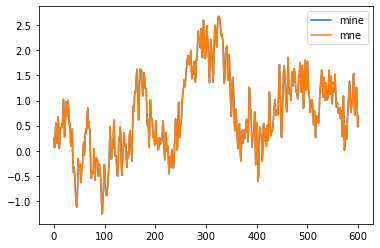

In [135]:
ch_num = 62
event_num = 1

# plt.plot(eeg_trials[ch_num,trial_num,:])

# plt.plot(ERP_array[event_num,ch_num,:])
events = ['S200','S201','S202']


Vmax = np.max(ERP1[events[event_num]][ch_num,:])
Vmin = np.min(ERP1[events[event_num]][ch_num,:])

temp = (ERP1[events[event_num]][ch_num,:]-Vmin)/(Vmax-Vmin)
# plt.plot(temp)
plt.plot(ERP1[events[event_num]][ch_num,:])

Vmax = np.max(ERP_array[event_num,ch_num,:])
Vmin = np.min(ERP_array[event_num,ch_num,:])

temp1 = (ERP_array[event_num,ch_num,:]-Vmin)/(Vmax-Vmin)

# plt.plot(temp1)
plt.plot(ERP_array[event_num,ch_num,:])

plt.legend(['mine','mne'])

In [134]:
temp = ERP_array[event_num,ch_num,:]-ERP1[events[event_num]][ch_num,:]

np.linalg.norm(temp)

0.06868210204433223